## 載入資料

In [1]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

## 載入sklearn提供的紅酒分類資料
wine = datasets.load_wine()

## 轉成dataframe
df = pd.DataFrame(data=np.c_[wine['data'], wine['target']],
                  columns=wine['feature_names']+['target'])

df

D:\Anaconda\envs\pytorch\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


## 資料前處理
##### 這裡實作使用的是數據型而非文字型資料進行小小分類任務練習
##### 數據型資料的前處理略有不同，文字型資料多了兩個步驟：處理文字之後特徵擷取，最後的表達會跟數據型資料一樣

### 缺失值處理及資料型態轉換
1. 確認資料是否有缺失值Non-Null Count，此份資料沒有(non-null)。有缺失值有(1)刪掉欄位、(2)刪掉列、(3)補平均值、(5)訓練模型預測該值等等的作法。
2. 確認各特徵的資料型態是否為可計算的型態(float、integer)，此份資料(Dtype)沒有不可計算的型態(如bool、objects)。如有，是資料內容做轉換。

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

### 離群值處理
3. 確認是否有離群值(outliers)，非必要，視模型而定，常用於對離群值敏感的模型，如logistic regression，而tree-based則較不易。離群值的偵測方式視正向分布情況而定，
    
    (1)符合正向分布：
        對稱 - 3倍標準差法將某個數據點大於或小於與樣本平均值差3倍標準差(Z-score)定義為離群值。
        非對稱 - 四分位數間距法，四分位距(IQR)就是上四分位與下四分位的差值。通過IQR的1.5倍為標準，定義超過上四分位+1.5倍IQR距離，或者小於下四分位-1.5倍IQR距離的點為離群值。
    (2)不符合正向分布：可以用孤立森林方法(isolation forest)將離群值定義為分佈稀疏且離密度高的群體較遠的點。表示資料發生在此區域的機率很低。 
    
   離群值的處理方式：(1)直接刪除、(2)用平均值調整、(3)填充Z-score或IQR*1.5值、(4)不處理等等。

{'alcohol': 'symmetric', 'malic_acid': 'highly skewed', 'ash': 'symmetric', 'alcalinity_of_ash': 'symmetric', 'magnesium': 'highly skewed', 'total_phenols': 'symmetric', 'flavanoids': 'symmetric', 'nonflavanoid_phenols': 'symmetric', 'proanthocyanins': 'moderately skewed', 'color_intensity': 'moderately skewed', 'hue': 'symmetric', 'od280/od315_of_diluted_wines': 'symmetric', 'proline': 'moderately skewed'}


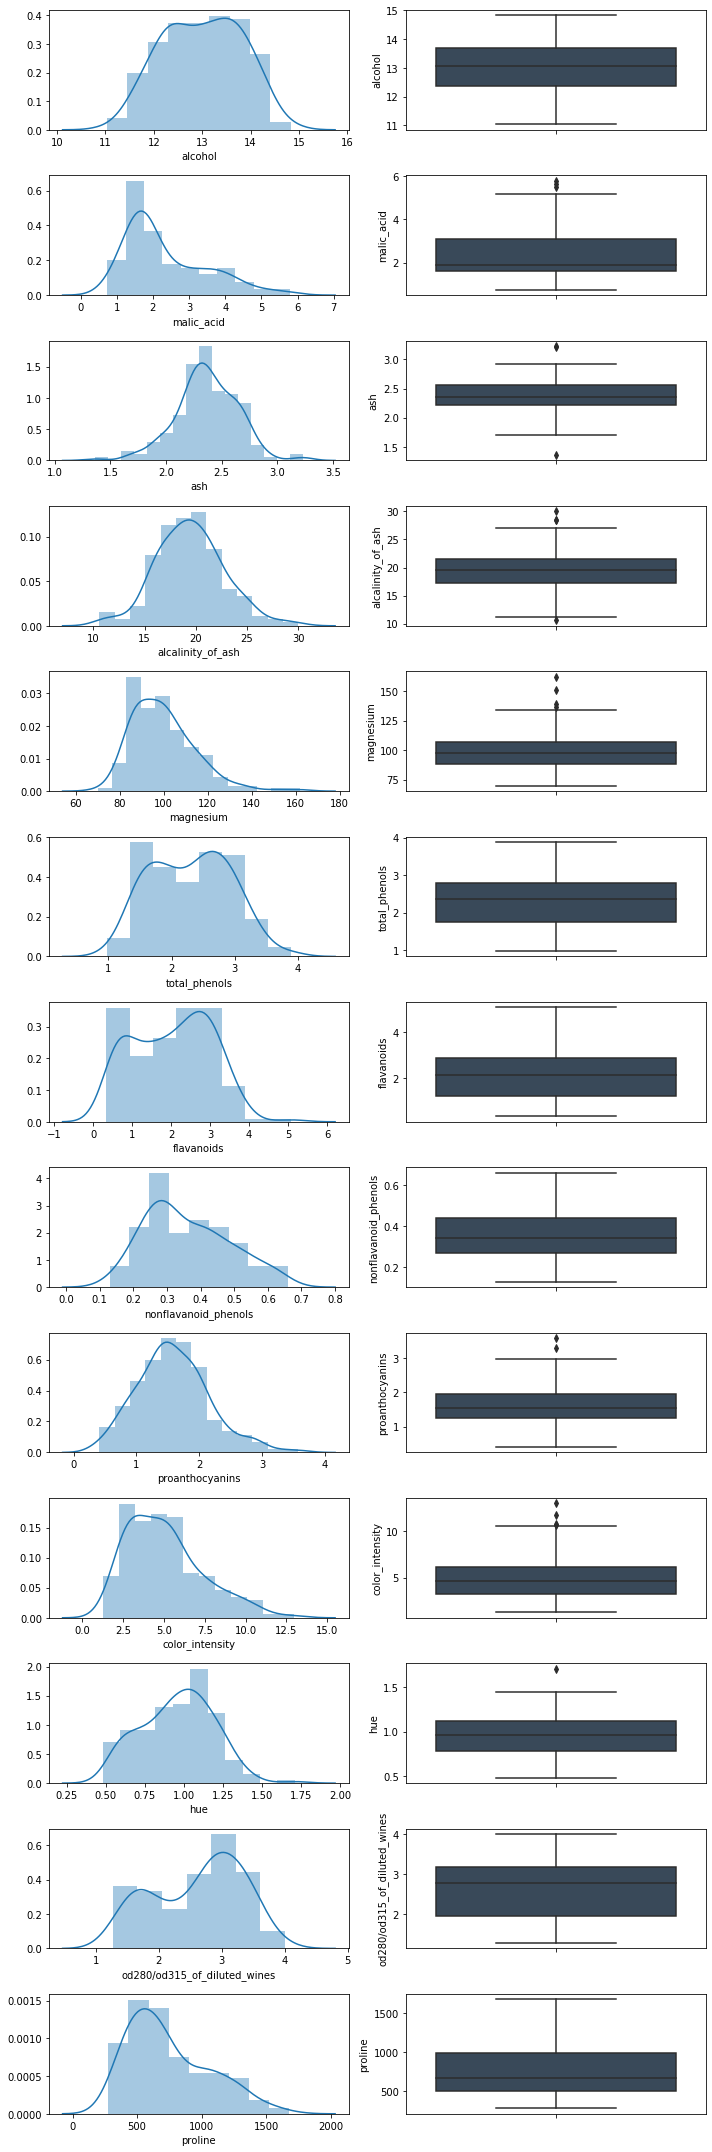

In [3]:
from scipy.stats import skew

## 畫一個由13*2個子圖組成的圖
fig, axes = plt.subplots(13, 2, figsize=(10,30))

## 因表格最後一欄是類別標註，所以:-1；又因左右都要畫某特徵的相關圖，所以他的名字要被用兩次
cols2plot = [c for c in df.columns[:-1] for x in range(2)]
## 空字典裝每個特徵的偏度(skewness)
cols_skewness = {}

## 共有26個子圖(ax)，一個特徵要配一張，所以zip起來。又因想要左邊是正向方佈圖，右邊是箱型圖故初始化i=2，
## 每次迴圈都加1，偶數時繪正向方佈圖，即在左邊，反之亦然。
i = 2
for name, ax in zip(cols2plot, axes.flatten()):
    if i % 2 == 0:
        sns.distplot(df[name], ax=ax)
    else:
        sns.boxplot(y=name, data=df, ax=ax, palette=["#34495e"])
    
    ## 偏度判斷
    if cols_skewness.get(name) is None:
        skewness = round(skew(df[name]), 2)
        if skewness <= -1 or skewness >= 1:
            cols_skewness[name] = "highly skewed"
        elif skewness > -0.5 and skewness < 0.5:
            cols_skewness[name] = "symmetric"
        elif skewness > -1 and skewness < -0.5:
            cols_skewness[name] = "moderately skewed"
        elif skewness > 0.5 and skewness < 1:
            cols_skewness[name] = "moderately skewed"
        
    i += 1

plt.tight_layout()
print(cols_skewness)

In [4]:
## 自定義離群值處理的函式(針對每個特徵處理)，需輸入:資料dataframe、每個特徵的偏度字典、
## 處理方式(trim:刪除；cap:填充Z-score*3(if normally distributed)、或IQR*1.5(if not normally distributed))
def outliers_treatment(df, cols_skewness, method):
    for col in cols_skewness:
        if cols_skewness.get(col) == "symmetric":
            highest_allowed = df[col].mean() + 3*df[col].std()
            lowest_allowed = df[col].mean() - 3*df[col].std()

            if len(df[(df[col] > highest_allowed) | (df[col] < lowest_allowed)]) >= 1:
                print("outliers index in "+col+":", df[(df[col] > highest_allowed) | (df[col] < lowest_allowed)].index)
                
        elif re.search("skewed", cols_skewness.get(col)):
            percentile25 = df[col].quantile(0.25)
            percentile75 = df[col].quantile(0.75)
            iqr = percentile75 - percentile25

            highest_allowed = percentile75 + 1.5 * iqr
            lowest_allowed = percentile25 - 1.5 * iqr
            if len(df[(df[col] > highest_allowed) | (df[col] < lowest_allowed)]) >= 1:
                print("outliers index in "+col+":", df[(df[col] > highest_allowed) | (df[col] < lowest_allowed)].index)
            
        if method == "trim":
            df = df[(df[col] < highest_allowed) & (df[col] > lowest_allowed)].reset_index(drop=True)
        elif method == "cap":
            df[col] = np.where(df[col]>highest_allowed,
                                highest_allowed,
                                np.where(df[col]<lowest_allowed,
                                        lowest_allowed,
                                        df[col]))
    return df

method = "trim"
df = outliers_treatment(df, cols_skewness, method)
df

outliers index in malic_acid: Int64Index([123, 137, 173], dtype='int64')
outliers index in ash: Int64Index([25, 59, 121], dtype='int64')
outliers index in alcalinity_of_ash: Int64Index([71], dtype='int64')
outliers index in magnesium: Int64Index([67, 75, 92], dtype='int64')
outliers index in proanthocyanins: Int64Index([14, 49, 104, 116], dtype='int64')
outliers index in color_intensity: Int64Index([138, 145, 146, 153], dtype='int64')
outliers index in hue: Int64Index([106], dtype='int64')


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,14.16,2.51,2.48,20.0,91.0,1.68,0.70,0.44,1.24,9.70,0.62,1.71,660.0,2.0
155,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
156,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
157,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


### 資料平衡檢查
4. 查看資料於各類是否平衡。若否，可以做資料增強(文字型資料須從文字方面增強)。

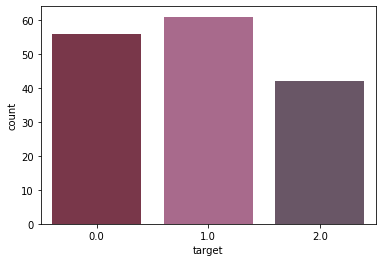

In [5]:
## 該資料看起來平衡。
wine = ["#842C46", "#B2608D", "#6C5368"]
ax = sns.countplot(x="target", data=df, palette=wine)

### 特徵縮放
5. 做資料標準化(standardization；不受離群值影響)或正規化(normalization；受離群值影響)。非必要，視模型而定，常用於SVM或KNN等基於數據點之間的距離來確定其相似性的模型。一般特徵篩選會使用標準或正規化後的資料，但沒有一定。

In [6]:
from sklearn.preprocessing import MinMaxScaler

## 複製一份資料用以做特徵縮放
df_normalized = df.copy()

## 這裡做資料正規化，將資料縮放到0-1之間
for col in df_normalized.iloc[:, :-1].columns:
    df_normalized[col] = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(df_normalized[col]).reshape(-1,1))

df_normalized

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,0.824561,0.217978,0.598361,0.254335,0.890625,0.627586,0.757660,0.283019,0.783333,0.471861,0.549451,0.970696,0.561341,0.0
1,0.523392,0.233708,0.360656,0.000000,0.468750,0.575862,0.674095,0.245283,0.362500,0.335498,0.560440,0.780220,0.550642,0.0
2,0.511696,0.364045,0.795082,0.427746,0.484375,0.627586,0.807799,0.320755,1.000000,0.476190,0.538462,0.695971,0.646933,0.0
3,0.865497,0.271910,0.655738,0.323699,0.671875,0.989655,0.877437,0.207547,0.737500,0.705628,0.351648,0.798535,0.857347,0.0
4,0.535088,0.415730,0.959016,0.566474,0.750000,0.627586,0.654596,0.490566,0.587500,0.329004,0.549451,0.608059,0.325963,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.804094,0.397753,0.639344,0.508671,0.328125,0.241379,0.100279,0.584906,0.345833,0.911255,0.087912,0.161172,0.272468,2.0
155,0.581871,0.712360,0.639344,0.682081,0.500000,0.282759,0.114206,0.566038,0.416667,0.651515,0.175824,0.106227,0.336662,2.0
156,0.543860,0.795506,0.459016,0.508671,0.781250,0.210345,0.097493,0.566038,0.391667,0.965368,0.054945,0.106227,0.397290,2.0
157,0.514620,0.415730,0.549180,0.508671,0.781250,0.231034,0.094708,0.754717,0.437500,0.867965,0.065934,0.128205,0.400856,2.0


### 特徵篩選
6. 特徵篩選有種方法，如過濾法、嵌入法、降維法等等，每個方法裡也有各式不同的統計方法。這裡介紹及使用過濾法裡的相關性過濾統計 - 相互資訊法(mutual information)用來檢驗每個特徵與類別之間是否有顯著性關係
   
**注意!並非所有低分特徵都需要被刪除，還是要根據人類需求與判斷決定去留**

In [7]:
from sklearn.feature_selection import mutual_info_classif

## 因要使用統計方法比較特徵跟類別間的關係，故須先定義特徵(X)和類別(y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## 介於0-1之間， 0：表示兩組數據相互獨立，1：表示兩組數據完全相關，結果值大於0的特徵(與標籤相關的特徵)
feature_scores = mutual_info_classif(X, y, random_state=0)

## 找出最高分的特徵，0.4是隨機設置的值，可以調整，或是只要前幾高就好也可以
high_score_features = []
for score, f_name in zip(feature_scores, X.columns):
    if score >= 0.4:
        high_score_features.append(f_name)

## 已經找出最相關的特徵，這裡只掉只要這些欄位。先不跟y(類別)合併，下面有要用到分開的地方
df_mic = X[high_score_features]
df_mic

,alcohol,total_phenols,flavanoids,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,2.80,3.06,5.64,1.04,3.92,1065.0
1,13.20,2.65,2.76,4.38,1.05,3.40,1050.0
2,13.16,2.80,3.24,5.68,1.03,3.17,1185.0
3,14.37,3.85,3.49,7.80,0.86,3.45,1480.0
4,13.24,2.80,2.69,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...
154,14.16,1.68,0.70,9.70,0.62,1.71,660.0
155,13.40,1.80,0.75,7.30,0.70,1.56,750.0
156,13.27,1.59,0.69,10.20,0.59,1.56,835.0
157,13.17,1.65,0.68,9.30,0.60,1.62,840.0


In [8]:
## 做特徵縮放後的資料的特徵篩選
X = df_normalized.iloc[:, :-1]

## 介於0-1之間， 0：表示兩組數據相互獨立，1：表示兩組數據完全相關，結果值大於0的特徵(與標籤相關的特徵)
feature_scores = mutual_info_classif(X, y, random_state=0)

high_score_features = []
for score, f_name in zip(feature_scores, X.columns):
    if score >= 0.4:
        high_score_features.append(f_name)
df_normalized_mic = X[high_score_features]
df_normalized_mic

,alcohol,total_phenols,flavanoids,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.824561,0.627586,0.757660,0.471861,0.549451,0.970696,0.561341
1,0.523392,0.575862,0.674095,0.335498,0.560440,0.780220,0.550642
2,0.511696,0.627586,0.807799,0.476190,0.538462,0.695971,0.646933
3,0.865497,0.989655,0.877437,0.705628,0.351648,0.798535,0.857347
4,0.535088,0.627586,0.654596,0.329004,0.549451,0.608059,0.325963
...,...,...,...,...,...,...,...
154,0.804094,0.241379,0.100279,0.911255,0.087912,0.161172,0.272468
155,0.581871,0.282759,0.114206,0.651515,0.175824,0.106227,0.336662
156,0.543860,0.210345,0.097493,0.965368,0.054945,0.106227,0.397290
157,0.514620,0.231034,0.094708,0.867965,0.065934,0.128205,0.400856


## 訓練及測試數據產生

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_mic.iloc[:, :-1], y, test_size=0.2, random_state=1)
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(df_normalized_mic.iloc[:, :-1], y, test_size=0.2, random_state=1)

## 模型訓練與評估

### Decision Tree

precision:  0.95
recall:     0.94
f1_score:   0.94
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.87      0.93        15
           2       0.80      1.00      0.89         4

    accuracy                           0.94        32
   macro avg       0.91      0.96      0.93        32
weighted avg       0.95      0.94      0.94        32



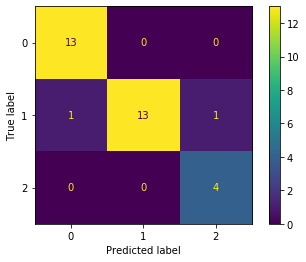

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 初始化分類器
dt_clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
## 訓練模型
dt_clf.fit(X_train, y_train)
## 預測測試集以做模型評估
y_pred = dt_clf.predict(X_test)

## 計算成績
print("precision: ", round(precision_score(y_test, y_pred, average='weighted'), 2))
print("recall:    ", round(recall_score(y_test, y_pred, average='weighted'), 2))
print("f1_score:  ", round(f1_score(y_test, y_pred, average='weighted'), 2))
target_names = ["0","1","2"]
## 分類結果回報
print(classification_report(y_test, y_pred, target_names=target_names))

## 混淆矩陣繪製
confusion_matrix_ = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, 
                                    display_labels=target_names)

cm_display.plot()
plt.show()

#### 超參數調優
##### 調整參數有多種方法，如格點搜尋法(Grid Search)、隨機搜尋法(Randomized Search)、貝葉斯優畫法(Bayes Optimization)等等。這裡使用隨機搜尋法

In [11]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

## 定義要調優的參數及要嘗試的值
hyper_params = {'max_depth': [2, 3, 5, 10, 20],
                'min_samples_leaf': [5, 10, 20, 50, 100],}

## 初始化調參函式，以f1分數作為評估參數組合的好壞
randomized_search = RandomizedSearchCV(dt_clf, hyper_params, random_state=0, scoring="f1")
randomized_search.fit(X_train, y_train)

## 將調參結果轉成表格印出，rank_test_score欄位排序最佳到最差組合，params欄位顯示參數組合
tuned_results_df = pd.DataFrame(randomized_search.cv_results_)
tuned_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002792,0.001317,0.018233,0.032975,5,3,"{'min_samples_leaf': 5, 'max_depth': 3}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.001996,0.000639,0.001794,0.000738,20,2,"{'min_samples_leaf': 20, 'max_depth': 2}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,0.001585,0.000478,0.001800,0.000400,100,10,"{'min_samples_leaf': 100, 'max_depth': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,0.002180,0.001151,0.002001,0.000622,10,10,"{'min_samples_leaf': 10, 'max_depth': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,0.001603,0.000495,0.002181,0.000392,10,5,"{'min_samples_leaf': 10, 'max_depth': 5}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


#### 用新參數訓練

precision:  0.97
recall:     0.97
f1_score:   0.97
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.93      0.97        15
           2       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32



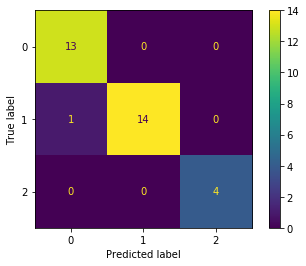

In [12]:
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

## 調參後f1 score進步0.03
print("precision: ", round(precision_score(y_test, y_pred, average='weighted'), 2))
print("recall:    ", round(recall_score(y_test, y_pred, average='weighted'), 2))
print("f1_score:  ", round(f1_score(y_test, y_pred, average='weighted'), 2))
target_names = ["0","1","2"]
print(classification_report(y_test, y_pred, target_names=target_names))

confusion_matrix_ = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, 
                                    display_labels=target_names)

cm_display.plot()
plt.show()

#### 儲存和載入模型

In [ ]:
# import pickle

# with open("dt_depth3_leaf5_f97.pkl", "wb") as file:
#     pickle.dump(svm_clf, file)
    
# with open("svm_gamm10_c1_f97.pkl", "rb") as file:
#     svm_clf = pickle.load(file)

#### 可視化decision tree

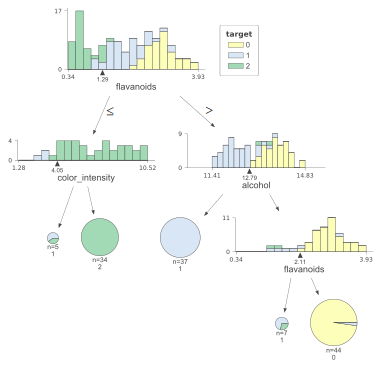

In [13]:
from sklearn import tree
from dtreeviz.trees import *
%matplotlib inline 

dtreeviz(dt_clf, 
         X_train, 
         y_train,
         target_name='target',
         feature_names=X_train.columns, 
         class_names=target_names) 

#### 查看對此模型來說重要特徵

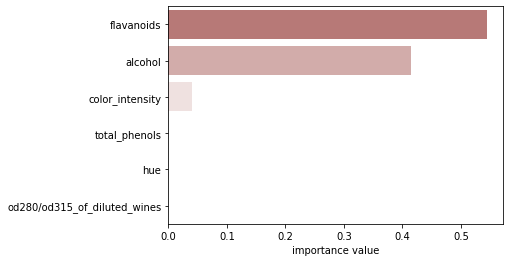

In [14]:
## 以字典裝特徵和他們的重要值並依高到低排序(重要度意為，該特徵在分類時做出的貢獻，
## 即使用他分類可以多大程度分開類別)
feature_importances = {f: dt_clf.feature_importances_[i] for i, f in enumerate(X_train.columns)}
feature_importances_sorted = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

## 將字典轉成兩個list(順序是有對應的)
keys = list(feature_importances_sorted.keys())
vals = [float(feature_importances_sorted[k]) for k in keys]

## 畫長條圖
sns.barplot(x=vals, y=keys, palette="vlag_r")
plt.xlabel("importance value")
plt.show()

#### 使用假的新wine data預測並可視化

fake and new data
    alcohol  total_phenols  flavanoids  color_intensity  hue  \
0       12              3           3                1    2   

   od280/od315_of_diluted_wines  
0                             2  
new data prediction: 1.0


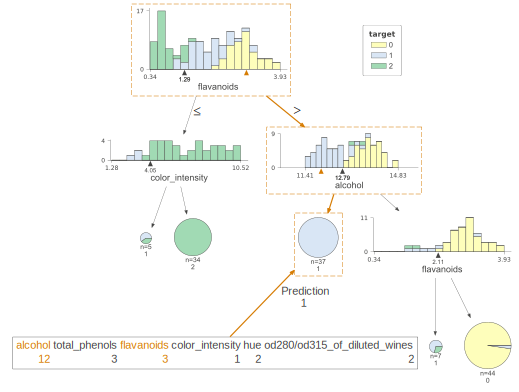

In [15]:
## 創建假資料並預測
pseudo_data = pd.DataFrame([[12, 3, 3, 1, 2, 2]], columns=X_train.columns)
pseudo_pred = dt_clf.predict(pseudo_data)
print("fake and new data\n", pseudo_data)
print("new data prediction:", str(pseudo_pred[0]))

## 可視化該資料於decision tree分類的路徑
dtreeviz(dt_clf, 
         X_train, 
         y_train,
         target_name='target',
         feature_names=X_train.columns, 
         class_names=target_names,
         X=pseudo_data.iloc[0])

### SVM

precision:  0.22
recall:     0.47
f1_score:   0.3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.47      1.00      0.64        15
           2       0.00      0.00      0.00         4

    accuracy                           0.47        32
   macro avg       0.16      0.33      0.21        32
weighted avg       0.22      0.47      0.30        32



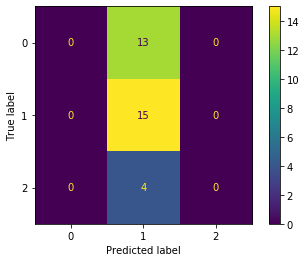

In [16]:
from sklearn.svm import SVC

## 跟decision tree一樣的步驟
svm_clf = SVC(kernel='rbf', gamma=0.1, C=0.1)
svm_clf.fit(X_train_nm, y_train_nm)
y_pred = svm_clf.predict(X_test_nm)

print("precision: ", round(precision_score(y_test_nm, y_pred, average='weighted'), 2))
print("recall:    ", round(recall_score(y_test_nm, y_pred, average='weighted'), 2))
print("f1_score:  ", round(f1_score(y_test_nm, y_pred, average='weighted'), 2))
target_names = ["0","1","2"]
print(classification_report(y_test_nm, y_pred, target_names=target_names))

confusion_matrix_ = confusion_matrix(y_test_nm, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, 
                                    display_labels=target_names)

cm_display.plot()
plt.show()

#### 超參數調優

In [17]:
## 跟decision tree一樣的步驟，只是參數不同
hyper_params = {"gamma": [0.1, 1, 10, 100],
                'C': [0.1, 1, 10]}
randomized_search = RandomizedSearchCV(svm_clf, hyper_params, random_state=0, scoring="f1")
randomized_search.fit(X_train_nm, y_train_nm)
tuned_results_df = pd.DataFrame(randomized_search.cv_results_)
tuned_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002582,0.000488,0.002804,0.000740,10,1,"{'gamma': 10, 'C': 1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.003191,0.000977,0.002799,0.000973,100,10,"{'gamma': 100, 'C': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,0.002199,0.000396,0.002187,0.000386,0.1,1,"{'gamma': 0.1, 'C': 1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,0.002192,0.000415,0.002002,0.000012,10,10,"{'gamma': 10, 'C': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,0.002194,0.000399,0.002401,0.000497,10,0.1,"{'gamma': 10, 'C': 0.1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


#### 用新參數訓練

precision:  0.97
recall:     0.97
f1_score:   0.97
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.93      0.97        15
           2       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32



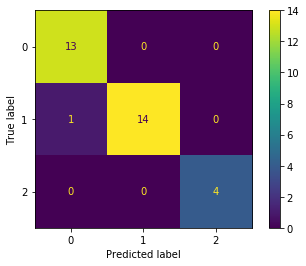

In [18]:
svm_clf = SVC(kernel='rbf', gamma=10, C=1)
svm_clf.fit(X_train_nm, y_train_nm)
y_pred = svm_clf.predict(X_test_nm)

## 調參後f1 score進步0.67
print("precision: ", round(precision_score(y_test_nm, y_pred, average='weighted'), 2))
print("recall:    ", round(recall_score(y_test_nm, y_pred, average='weighted'), 2))
print("f1_score:  ", round(f1_score(y_test_nm, y_pred, average='weighted'), 2))
target_names = ["0","1","2"]
print(classification_report(y_test_nm, y_pred, target_names=target_names))

confusion_matrix_ = confusion_matrix(y_test_nm, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, 
                                    display_labels=target_names)

cm_display.plot()
plt.show()

#### 儲存和載入模型

In [ ]:
# import pickle

# with open("svm_gamm10_c1_f97.pkl", "wb") as file:
#     pickle.dump(svm_clf, file)
    
# with open("svm_gamm10_c1_f97.pkl", "rb") as file:
#     svm_clf = pickle.load(file)

#### 可視化SVM
##### 實作只提供可視化兩維，所以需選擇兩個特徵重新訓練只有兩個特徵的SVM畫圖。這裡特徵篩選後有六個特徵，六維資料畫不出來。

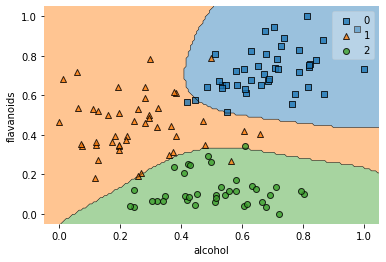

In [22]:
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

## 自定義SVM可視化，需輸入訓練集資料、兩個要可視化的特徵(list)、兩個參數(gamma、C)
def svm_vizualize(X_train_nm, columns2plot, gamma, C):
    col2plot_id = [i for i, c in enumerate(X_train_nm.columns) if c in columns2plot]
    X = X_train_nm.iloc[:, col2plot_id].to_numpy()

    svm_clf_twod = SVC(kernel='rbf', gamma=gamma, C=C)
    svm_clf_twod.fit(X, y_train_nm.to_numpy())

    plot_decision_regions(X=X, y=y_train_nm.astype(np.int_).to_numpy(), clf=svm_clf_twod, legend=1)
    plt.xlim([min(X_train_nm[columns2plot[0]])-0.05,max(X_train_nm[columns2plot[0]])+0.05])
    plt.xlabel(columns2plot[0])
    plt.ylim([min(X_train_nm[columns2plot[1]])-0.05,max(X_train_nm[columns2plot[1]])+0.05])
    plt.ylabel(columns2plot[1])
    plt.show()
    
columns2plot = ["alcohol", "flavanoids"]
svm_vizualize(X_train_nm, columns2plot, gamma=10, C=2)

#### 查看對此模型來說重要特徵

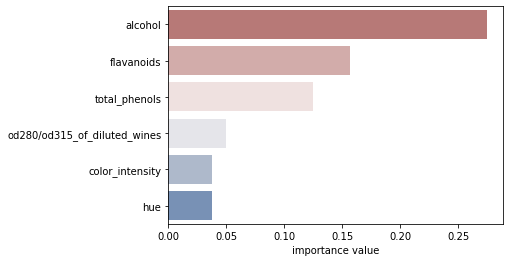

In [23]:
from sklearn.inspection import permutation_importance

## 計算SVM分類時的特徵重要度
perm_importance = permutation_importance(svm_clf, X_test_nm, y_test_nm)

## 跟decision tree步驟一樣
feature_importances = {f: perm_importance.importances_mean[i] for i, f in enumerate(X_train_nm.columns)}
feature_importances_sorted = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

keys = list(feature_importances_sorted.keys())
vals = [float(feature_importances_sorted[k]) for k in keys]
sns.barplot(x=vals, y=keys, palette="vlag_r")
plt.xlabel("importance value")
plt.show()

#### 使用假的新wine data預測和可視化

In [24]:
## 跟decision tree步驟一樣
pseudo_data = pd.DataFrame([[1, 0.6, 0.2, 0.1, 0.3, 0.7]], columns=X_train_nm.columns)
pseudo_pred = svm_clf.predict(pseudo_data)
print("fake and new data\n", pseudo_data)
print("new data prediction:", str(pseudo_pred[0]))

fake and new data
    alcohol  total_phenols  flavanoids  color_intensity  hue  \
0        1            0.6         0.2              0.1  0.3   

   od280/od315_of_diluted_wines  
0                           0.7  
new data prediction: 1.0


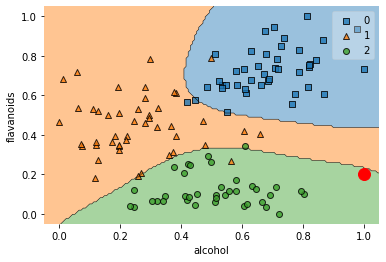

In [25]:
## 跟上面SVM可視化函式一樣，這裡需再放剛剛創建的假資料
def svm_vizualize(X_train_nm, columns2plot, gamma, C, pseudo_data):
    col2plot_id = [i for i, c in enumerate(X_train_nm.columns) if c in columns2plot]
    X = X_train_nm.iloc[:, col2plot_id].to_numpy()
    pseud_X = pseudo_data.iloc[:, col2plot_id].to_numpy()

    svm_clf_twod = SVC(kernel='rbf', gamma=gamma, C=C)
    svm_clf_twod.fit(X, y_train_nm.to_numpy())

    pseudo_pred = svm_clf_twod.predict(pseud_X)[0]

    ax = plot_decision_regions(X=X, y=y_train_nm.astype(np.int_).to_numpy(), clf=svm_clf_twod, legend=1)
    plt.xlim([min(X_train_nm[columns2plot[0]])-0.05,max(X_train_nm[columns2plot[0]])+0.05])
    plt.xlabel(columns2plot[0])
    plt.ylim([min(X_train_nm[columns2plot[1]])-0.05,max(X_train_nm[columns2plot[1]])+0.05])
    plt.ylabel(columns2plot[1])

    if pseudo_pred == 0: ax.plot(pseud_X[0][0], pseud_X[0][1], 's', markersize=12, color="red")
    elif pseudo_pred == 1: ax.plot(pseud_X[0][0], pseud_X[0][1], '^', markersize=12, color="red")
    elif pseudo_pred == 2: ax.plot(pseud_X[0][0], pseud_X[0][1], 'o', markersize=12, color="red")

    plt.show()
    
## 注意!因為這裡是只用兩個特徵進行訓練、預測和繪圖，可能會和原本SVM的預測結果不同
## 新數據以紅色圖樣標出
columns2plot = ["alcohol", "flavanoids"]
svm_vizualize(X_train_nm, columns2plot, gamma=10, C=2, pseudo_data=pseudo_data)